In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

# Load the stored DataFrame using pickle
with open('MaldiniNet.pickle', 'rb') as f:
    df = pickle.load(f)

df['home_advantage'] = df['home_xG'] - df['away_xG']

# Calculate the mean home advantage per home team for each season
mean_home_advantages = df.groupby(['season', 'home_team'])['home_advantage'].mean().reset_index()

# Normalize home advantage values
scaler = StandardScaler()
normalized_home_advantages = scaler.fit_transform(mean_home_advantages['home_advantage'].values.reshape(-1, 1))

# Create a mapping dictionary of (season, team) tuple to normalized home advantage
season_team_home_advantage_mapping = {
    (season, team): normalized_home_advantages[i][0] for i, (season, team) in enumerate(mean_home_advantages[['season', 'home_team']].values)
}

# Map normalized home advantage values back to the main DataFrame using (season, home_team) as keys
df['home_advantage'] = df.apply(lambda row: season_team_home_advantage_mapping.get((row['season'], row['home_team']), np.nan), axis=1)

df = df.drop(['home_xG', 'away_xG'], axis=1)

df[['home_win_prob', 'draw_prob', 'away_win_prob']] = df[['home_win_prob', 'draw_prob', 'away_win_prob']].astype(float)

# Identify and drop subsequent duplicate columns, keeping the first instance
df = df.loc[:, ~df.columns.duplicated(keep='first')]

df = df[df['draw_prob'] <= 0.40]


In [2]:
# Filter data for training based on the date (before February 1, 2023)
training_data = df[df['date'] < '2023-01-01']

validation_data = df[df['date'] >= '2023-01-01']

print("The number of rows in the training data is:",len(training_data))
print("The number of rows in the validation data is:",len(validation_data))

The number of rows in the training data is: 11464
The number of rows in the validation data is: 799


In [11]:
import numpy as np
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=25,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Define the input features and target columns
input_features = ['home_directfk_xG', 'home_corner_xG', 'home_op_xG', 'home_pen_xG',
       'home_setpiece_xG', 'home_directfk_shots_ot', 'home_corner_shots_ot',
       'home_op_shots_ot', 'home_pen_shots_ot', 'home_setpiece_shots_ot',
       'home_directfk_shots', 'home_corner_shots', 'home_op_shots',
       'home_pen_shots', 'home_setpiece_shots', 'home_directfk_goals',
       'home_corner_goals', 'home_op_goals', 'home_pen_goals',
       'home_setpiece_goals', 'away_directfk_xG', 'away_corner_xG',
       'away_op_xG', 'away_pen_xG', 'away_setpiece_xG',
       'away_directfk_shots_ot', 'away_corner_shots_ot', 'away_op_shots_ot',
       'away_pen_shots_ot', 'away_setpiece_shots_ot', 'away_directfk_shots',
       'away_corner_shots', 'away_op_shots', 'away_pen_shots',
       'away_setpiece_shots','away_directfk_goals','away_corner_shots', 'away_op_shots', 'away_pen_shots',
       'away_setpiece_shots', 'away_directfk_goals',
       'away_corner_goals', 'away_op_goals', 'away_pen_goals',
       'away_setpiece_goals','home_advantage']

target_columns = ['home_win_prob', 'draw_prob','away_win_prob']

# Prepare the input data and target labels
X = training_data[input_features].values
y = training_data[target_columns].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardize the input data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model with L2 regularization
home_input = layers.Input(shape=(X_train_scaled.shape[1],), name='home_input')
away_input = layers.Input(shape=(X_train_scaled.shape[1],), name='away_input')

shared_layer1 = layers.Dense(12, activation='relu', kernel_regularizer=l2(0.01))
shared_layer2 = layers.Dense(6, activation='relu', kernel_regularizer=l2(0.01))

home_branch = shared_layer2(shared_layer1(home_input))
away_branch = shared_layer2(shared_layer1(away_input))

merged_branches = layers.concatenate([home_branch, away_branch])

output_layer = layers.Dense(3, activation='softmax')(merged_branches)

model = keras.Model(inputs=[home_input, away_input], outputs=output_layer)

# Define the learning rate and create the optimizer
learning_rate = 0.001
amsgrad = False
optimizer = Adam(learning_rate=learning_rate, amsgrad=amsgrad)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(
    [X_train_scaled, X_train_scaled], y_train,
    epochs=300, batch_size=16,
    validation_data=([X_test_scaled, X_test_scaled], y_test),
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss = model.evaluate([X_test_scaled, X_test_scaled], y_test)
print(f"Test loss: {test_loss:.4f}")

# Print training loss for each epoch
training_loss = history.history['loss']
for epoch, train_loss in enumerate(training_loss):
    print(f"Epoch {epoch + 1}: Train loss = {train_loss:.4f}")

# Save the trained model and the scaler
model.save('MaldiniNet_robust_validation.h5')
print("Model saved successfully.")

#Calculate rolling averages for each home team and away team in the validation set
rolling_window_size = 6

validation_rolling_home_averages = []
validation_rolling_away_averages = []

for i in range(len(validation_data)):
    validation_match = validation_data.iloc[i]
    home_team = validation_match['home_team']
    away_team = validation_match['away_team']

    # Get the last 6 games for the current home team and away team from the training data
    home_window_data = training_data[training_data['home_team'] == home_team].tail(rolling_window_size)
    away_window_data = training_data[training_data['away_team'] == away_team].tail(rolling_window_size)

    if len(home_window_data) < rolling_window_size:
        # Extend the window using training data until 6 games are available
        missing_games = rolling_window_size - len(home_window_data)
        home_window_data = pd.concat([training_data[training_data['home_team'] == home_team].tail(rolling_window_size - len(home_window_data)), home_window_data])
    if len(away_window_data) < rolling_window_size:
        # Extend the window using training data until 6 games are available
        missing_games = rolling_window_size - len(away_window_data)
        away_window_data = pd.concat([training_data[training_data['away_team'] == away_team].tail(rolling_window_size - len(away_window_data)), away_window_data])

    # Calculate the rolling average for home team and away team
    rolling_home_average = home_window_data[input_features].mean(axis=0)
    rolling_away_average = away_window_data[input_features].mean(axis=0)

    validation_rolling_home_averages.append(rolling_home_average)
    validation_rolling_away_averages.append(rolling_away_average)

# Convert the lists of rolling averages to numpy arrays
validation_rolling_home_averages = np.array(validation_rolling_home_averages)
validation_rolling_away_averages = np.array(validation_rolling_away_averages)

# Scale the rolling averages using the same scaler used for training data
validation_rolling_home_averages_scaled = scaler.transform(validation_rolling_home_averages)
validation_rolling_away_averages_scaled = scaler.transform(validation_rolling_away_averages)

# Make predictions on the scaled rolling averages using the trained model
validation_predictions = model.predict([validation_rolling_home_averages_scaled, validation_rolling_away_averages_scaled])

# Add the predicted probabilities to the validation data DataFrame
validation_data['pred_home_win'] = validation_predictions[:, 0]
validation_data['pred_draw'] = validation_predictions[:, 1]
validation_data['pred_away_win'] = validation_predictions[:, 2]


print("Network creation complete!")


Epoch 1/300
574/574 [==============================] - 2s 2ms/step - loss: 0.1076 - val_loss: 0.0252
Epoch 2/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0171 - val_loss: 0.0126
Epoch 3/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0110 - val_loss: 0.0094
Epoch 4/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 5/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 6/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 7/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 8/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 9/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 10/300
574/574 [==============================] - 2s 3ms/step - loss: 0.0055 - val_lo

C:\Users\paulc\AppData\Local\Temp\ipykernel_12076\3481043329.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['pred_home_win'] = validation_predictions[:, 0]
C:\Users\paulc\AppData\Local\Temp\ipykernel_12076\3481043329.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['pred_draw'] = validation_predictions[:, 1]
C:\Users\paulc\AppData\Local\Temp\ipykernel_12076\3481043329.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

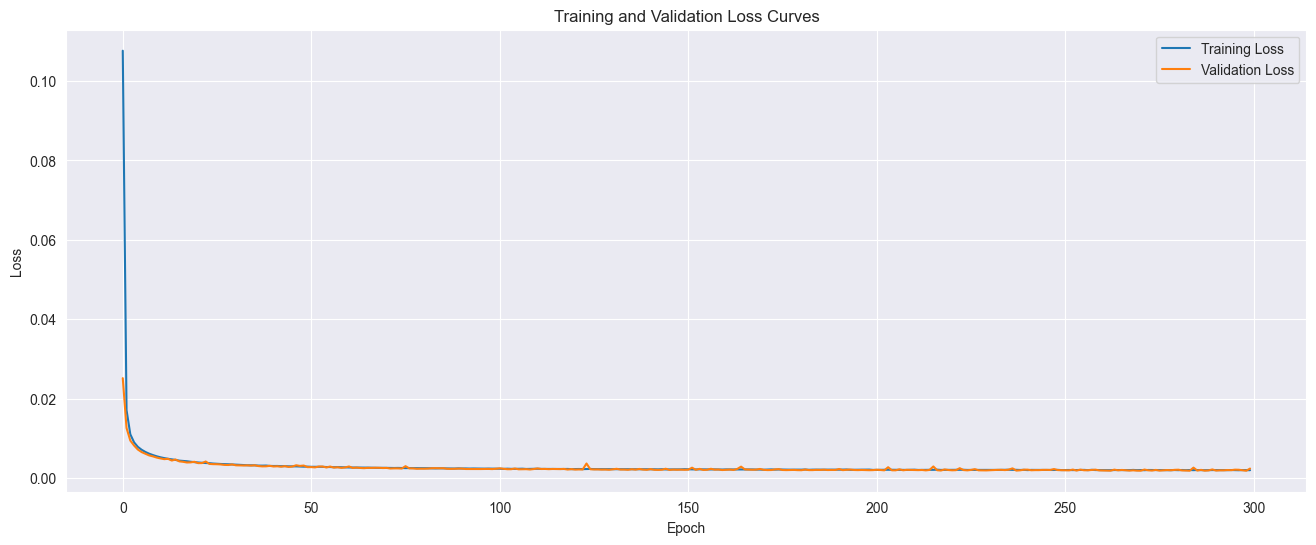

In [12]:
from matplotlib import pyplot as plt

# Plot the loss curves
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [133]:
import numpy as np
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=25,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Define the input features and target columns
input_features = ['home_directfk_xG', 'home_corner_xG', 'home_op_xG', 'home_pen_xG',
       'home_setpiece_xG', 'home_directfk_shots_ot', 'home_corner_shots_ot',
       'home_op_shots_ot', 'home_pen_shots_ot', 'home_setpiece_shots_ot',
       'home_directfk_shots', 'home_corner_shots', 'home_op_shots',
       'home_pen_shots', 'home_setpiece_shots', 'home_directfk_goals',
       'home_corner_goals', 'home_op_goals', 'home_pen_goals',
       'home_setpiece_goals', 'away_directfk_xG', 'away_corner_xG',
       'away_op_xG', 'away_pen_xG', 'away_setpiece_xG',
       'away_directfk_shots_ot', 'away_corner_shots_ot', 'away_op_shots_ot',
       'away_pen_shots_ot', 'away_setpiece_shots_ot', 'away_directfk_shots',
       'away_corner_shots', 'away_op_shots', 'away_pen_shots',
       'away_setpiece_shots','away_directfk_goals','away_corner_shots', 'away_op_shots', 'away_pen_shots',
       'away_setpiece_shots', 'away_directfk_goals',
       'away_corner_goals', 'away_op_goals', 'away_pen_goals',
       'away_setpiece_goals','home_advantage']

target_columns = ['home_win_prob', 'draw_prob','away_win_prob']

# Prepare the input data and target labels
X = training_data[input_features].values
y = training_data[target_columns].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardize the input data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model with L2 regularization
home_input = layers.Input(shape=(X_train_scaled.shape[1],), name='home_input')
away_input = layers.Input(shape=(X_train_scaled.shape[1],), name='away_input')

shared_layer1 = layers.Dense(12, activation='relu', kernel_regularizer=l2(0.01))
shared_layer2 = layers.Dense(6, activation='relu', kernel_regularizer=l2(0.01))

home_branch = shared_layer2(shared_layer1(home_input))
away_branch = shared_layer2(shared_layer1(away_input))

merged_branches = layers.concatenate([home_branch, away_branch])

output_layer = layers.Dense(3, activation='softmax')(merged_branches)

model = keras.Model(inputs=[home_input, away_input], outputs=output_layer)

# Define the learning rate and create the optimizer
learning_rate = 0.001
amsgrad = False
optimizer = Adam(learning_rate=learning_rate, amsgrad=amsgrad)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(
    [X_train_scaled, X_train_scaled], y_train,
    epochs=300, batch_size=16,
    validation_data=([X_test_scaled, X_test_scaled], y_test),
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss = model.evaluate([X_test_scaled, X_test_scaled], y_test)
print(f"Test loss: {test_loss:.4f}")

# Print training loss for each epoch
training_loss = history.history['loss']
for epoch, train_loss in enumerate(training_loss):
    print(f"Epoch {epoch + 1}: Train loss = {train_loss:.4f}")

# Save the trained model and the scaler
model.save('MaldiniNet_minmax_validation.h5')
print("Model saved successfully.")

#Calculate rolling averages for each home team and away team in the validation set
rolling_window_size = 6

validation_rolling_home_averages = []
validation_rolling_away_averages = []

for i in range(len(validation_data)):
    validation_match = validation_data.iloc[i]
    home_team = validation_match['home_team']
    away_team = validation_match['away_team']

    # Get the last 6 games for the current home team and away team from the training data
    home_window_data = training_data[training_data['home_team'] == home_team].tail(rolling_window_size)
    away_window_data = training_data[training_data['away_team'] == away_team].tail(rolling_window_size)

    if len(home_window_data) < rolling_window_size:
        # Extend the window using training data until 6 games are available
        missing_games = rolling_window_size - len(home_window_data)
        home_window_data = pd.concat([training_data[training_data['home_team'] == home_team].tail(rolling_window_size - len(home_window_data)), home_window_data])
    if len(away_window_data) < rolling_window_size:
        # Extend the window using training data until 6 games are available
        missing_games = rolling_window_size - len(away_window_data)
        away_window_data = pd.concat([training_data[training_data['away_team'] == away_team].tail(rolling_window_size - len(away_window_data)), away_window_data])

    # Calculate the rolling average for home team and away team
    rolling_home_average = home_window_data[input_features].mean(axis=0)
    rolling_away_average = away_window_data[input_features].mean(axis=0)

    validation_rolling_home_averages.append(rolling_home_average)
    validation_rolling_away_averages.append(rolling_away_average)

# Convert the lists of rolling averages to numpy arrays
validation_rolling_home_averages = np.array(validation_rolling_home_averages)
validation_rolling_away_averages = np.array(validation_rolling_away_averages)

# Scale the rolling averages using the same scaler used for training data
validation_rolling_home_averages_scaled = scaler.transform(validation_rolling_home_averages)
validation_rolling_away_averages_scaled = scaler.transform(validation_rolling_away_averages)

# Make predictions on the scaled rolling averages using the trained model
validation_predictions = model.predict([validation_rolling_home_averages_scaled, validation_rolling_away_averages_scaled])

# Add the predicted probabilities to the validation data DataFrame
validation_data['pred_home_win'] = validation_predictions[:, 0]
validation_data['pred_draw'] = validation_predictions[:, 1]
validation_data['pred_away_win'] = validation_predictions[:, 2]


print("Network creation complete!")


Epoch 1/300
574/574 [==============================] - 2s 2ms/step - loss: 0.0979 - val_loss: 0.0363
Epoch 2/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0305 - val_loss: 0.0267
Epoch 3/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0252 - val_loss: 0.0233
Epoch 4/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0224 - val_loss: 0.0216
Epoch 5/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0200
Epoch 6/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0183
Epoch 7/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0165
Epoch 8/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0156
Epoch 9/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0156 - val_loss: 0.0148
Epoch 10/300
574/574 [==============================] - 1s 2ms/step - loss: 0.0149 - val_lo

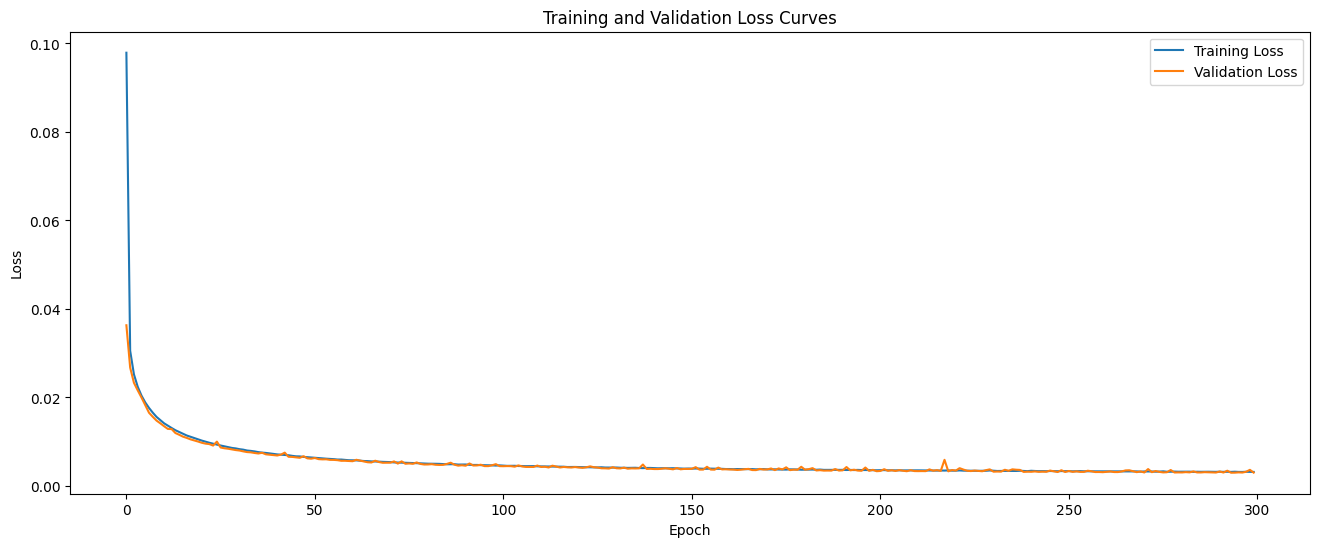

In [134]:
from matplotlib import pyplot as plt

# Plot the loss curves
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [14]:
validation_data_test = validation_data.copy()
validation_data_test = validation_data_test[['season','league','home_team','away_team','pred_home_win','pred_draw','pred_away_win']]
#Add a new column for the sum of predicted probabilities
validation_data_test['prob_Sum'] = validation_data_test[['pred_home_win', 'pred_draw', 'pred_away_win']].sum(axis=1)

validation_data_test['home_odds'] = 1 / validation_data_test['pred_home_win']
validation_data_test['draw_odds'] = 1 / validation_data_test['pred_draw']
validation_data_test['away_odds'] = 1 / validation_data_test['pred_away_win']

In [15]:
import warnings
warnings.filterwarnings('ignore')

validation_data_test['pred_home_odds'] = 1 / validation_data_test['pred_home_win']
validation_data_test['pred_draw_odds'] = 1 / validation_data_test['pred_draw']
validation_data_test['pred_away_odds'] = 1 / validation_data_test['pred_away_win']
closingOdds = pd.read_csv('closingOdds.csv')

In [16]:
validation_data_test = validation_data_test.merge(closingOdds,on=["home_team", "away_team"], how="inner")
validation_data_test

,season,league,home_team,away_team,pred_home_win,pred_draw,pred_away_win,prob_Sum,home_odds,draw_odds,...,pred_away_odds,homeOdds_100%,drawOdds_100%,awayOdds_100%,HomeGoals,AwayGoals,Overround,Home,Draw,Away
0,2022,Ligue1,Toulouse,Ajaccio,0.350041,0.311974,0.337984,1.0,2.856805,3.205392,...,2.958717,2.19,3.54,3.83,2.0,0.0,0.05279,1,0,0
1,2022,EPL,Tottenham,Aston Villa,0.767854,0.178990,0.053156,1.0,1.302330,5.586908,...,18.812611,1.70,4.36,5.50,0.0,2.0,0.04044,0,0,1
2,2022,Ligue1,Monaco,Brest,0.374584,0.311790,0.313626,1.0,2.669627,3.207285,...,3.188515,1.53,5.02,6.78,1.0,0.0,0.05410,1,0,0
3,2022,Ligue1,Angers,Lorient,0.318940,0.312186,0.368874,1.0,3.135384,3.203223,...,2.710952,2.66,3.54,2.93,1.0,2.0,0.05152,0,0,1
4,2022,Ligue1,Nantes,Auxerre,0.645053,0.241981,0.112966,1.0,1.550259,4.132555,...,8.852255,1.93,3.65,4.82,1.0,0.0,0.04967,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,2022,Ligue1,Marseille,Strasbourg,0.571781,0.268639,0.159580,1.0,1.748921,3.722464,...,6.266467,1.44,5.13,9.15,2.0,2.0,0.05522,0,1,0
773,2022,SerieA,Juventus,Sampdoria,0.702580,0.214457,0.082962,1.0,1.423325,4.662930,...,12.053665,1.38,5.14,12.41,4.0,2.0,0.04707,1,0,0
774,2022,Bundesliga,FC Cologne,Hertha Berlin,0.575869,0.268907,0.155223,1.0,1.736506,3.718751,...,6.442325,1.96,4.00,4.15,5.0,2.0,0.04386,1,0,0
775,2022,SerieA,Lazio,Lecce,0.622807,0.250957,0.126236,1.0,1.605633,3.984753,...,7.921667,1.72,3.83,6.30,2.0,2.0,0.04539,0,1,0


In [17]:
validation_data_test['homeOdds_100%'] = 1/ validation_data_test['homeOdds_100%']
validation_data_test['drawOdds_100%'] = 1/ validation_data_test['drawOdds_100%']
validation_data_test['awayOdds_100%'] = 1/ validation_data_test['awayOdds_100%']

In [18]:
# Calculate the differences between predicted and actual odds
validation_data_test["diff_homeOdds"] = validation_data_test["pred_home_win"] - validation_data_test["homeOdds_100%"]
validation_data_test["diff_drawOdds"] = validation_data_test["pred_draw"] - validation_data_test["drawOdds_100%"]
validation_data_test["diff_awayOdds"] = validation_data_test["pred_away_win"] - validation_data_test["awayOdds_100%"]

In [19]:
validation_data_test = validation_data_test[['season','league','home_team','away_team','pred_home_win','pred_draw','pred_away_win','homeOdds_100%','drawOdds_100%','awayOdds_100%','diff_homeOdds','diff_drawOdds','diff_awayOdds','Home','Draw','Away']]

validation_data_test[['homeOdds_100%_odds','drawOdds_100%_odds','awayOdds_100%_odds']] = 1/validation_data_test[['homeOdds_100%','drawOdds_100%','awayOdds_100%']]

In [20]:
validation_data_test.to_csv('validation.csv',index=False)

In [27]:
# Create an empty DataFrame to store the results
roi_results = pd.DataFrame(columns=['Diff Odds Range', 'Total Investment', 'Total ROI (Home Wins)', 'Number of Rows with Bet', 'ROI Percentage'])

# Iterate over the diff_odds ranges and calculate ROI for each range
for diff_odds in np.arange(0.01, 0.21, 0.01):
    min_diff_odds = diff_odds
    max_diff_odds = diff_odds + 0.01

    # Simulate betting and calculate ROI for home wins within the current range
    validation_data_test["bet_home"] = validation_data_test["diff_homeOdds"].apply(lambda x: 10 if min_diff_odds <= x < max_diff_odds else 0)

    # Calculate ROI for home wins
    validation_data_test["roi_home"] = validation_data_test.apply(
        lambda row: (10 * row["homeOdds_100%_odds"] - 10) if (row["Home"] == 1 and row["bet_home"] == 10) else (-10 if row["Home"] != 1 and row['bet_home'] == 10 else 0),
        axis=1
    )

    # Calculate total investment and total ROI for home wins
    total_investment = validation_data_test["bet_home"].sum()
    total_roi_home = validation_data_test["roi_home"].sum()
    num_rows_with_bet = (validation_data_test["bet_home"] > 0).sum()
    roi_percentage = total_roi_home / total_investment if total_investment > 0 else 0

    # Append the results to the DataFrame
    roi_results = roi_results.append({
        'Diff Odds Range': f'{min_diff_odds:.2f} - {max_diff_odds:.2f}',
        'Total Investment': total_investment,
        'Total ROI (Home Wins)': total_roi_home,
        'Number of Rows with Bet': num_rows_with_bet,
        'ROI Percentage': roi_percentage
    }, ignore_index=True)

# Display the results DataFrame
print(roi_results)


   Diff Odds Range Total Investment Total ROI (Home Wins)  \
0      0.01 - 0.02              300                 103.7   
1      0.02 - 0.03              170                 -15.6   
2      0.03 - 0.04              250                  66.2   
3      0.04 - 0.05              300                  80.9   
4      0.05 - 0.06              260                  -9.4   
5      0.06 - 0.07              170                  17.4   
6      0.07 - 0.08              230                 -24.9   
7      0.08 - 0.09              280                  13.5   
8      0.09 - 0.10              230                 -90.9   
9      0.10 - 0.11              160                   6.2   
10     0.11 - 0.12              250                 166.3   
11     0.12 - 0.13              340                   2.9   
12     0.13 - 0.14               80                  -8.5   
13     0.14 - 0.15              210                 -77.2   
14     0.15 - 0.16              170                 -84.5   
15     0.16 - 0.17      

In [34]:
# Simulate betting and calculate ROI
validation_data_test["bet_home"] = 0

validation_data_test["bet_home"] = validation_data_test["diff_homeOdds"].apply(lambda x: 10 if x > 0.20 else 0)

# Calculate ROI for home wins
validation_data_test["roi_home"] = validation_data_test.apply(
    lambda row: (10 * row["homeOdds_100%_odds"] - 10) if (row["Home"] == 1 and row["bet_home"] == 10) else (-10 if row["Home"] != 1 and row['bet_home'] == 10 else 0),
    axis=1
)


# Calculate total investment and total ROI for home wins
total_investment = validation_data_test["bet_home"].sum()
total_roi_home = validation_data_test["roi_home"].sum()
# Calculate the number of rows where bet_home > 0
num_rows_with_bet = (validation_data_test["bet_home"] > 0).sum()

print("Total Investment:", total_investment)
print("Total ROI (Home Wins):", total_roi_home)
print("Number of Rows with Bet:", num_rows_with_bet)
print("ROI Percentage:", round(total_roi_home / total_investment, 5))

Total Investment: 680
Total ROI (Home Wins): 67.19999999999997
Number of Rows with Bet: 68
ROI Percentage: 0.09882


In [42]:
# Simulate betting and calculate ROI
validation_data_test["bet_draw"] = 0

validation_data_test["bet_draw"] = validation_data_test["diff_drawOdds"].apply(lambda x: 10 if x > 0.20 else 0)

# Calculate ROI for home wins
validation_data_test["roi_draw"] = validation_data_test.apply(
    lambda row: (10 * row["drawOdds_100%_odds"] - 10) if (row["Draw"] == 1 and row["bet_draw"] == 10) else (-10 if row["Draw"] != 1 and row['bet_draw'] == 10 else 0),
    axis=1
)


# Calculate total investment and total ROI for home wins
total_investment = validation_data_test["bet_draw"].sum()
total_roi_draw = validation_data_test["roi_draw"].sum()
# Calculate the number of rows where bet_home > 0
num_rows_with_bet = (validation_data_test["bet_draw"] > 0).sum()
print("Total Investment:", total_investment)
print("Total ROI (draw Wins):", total_roi_draw)
print("Number of Rows with Bet:", num_rows_with_bet)
print("ROI Percentage:", round(total_roi_draw/total_investment,5))

Total Investment: 10
Total ROI (draw Wins): -10
Number of Rows with Bet: 1
ROI Percentage: -1.0


In [48]:
# Simulate betting and calculate ROI
validation_data_test["bet_away"] = 0
validation_data_test["bet_away"] = validation_data_test["diff_awayOdds"].apply(lambda x: 10 if x > 0.20 else 0)

# Calculate ROI for home wins
validation_data_test["roi_away"] = validation_data_test.apply(
    lambda row: (10 * row["drawOdds_100%_odds"] - 10) if (row["Away"] == 1 and row["bet_away"] == 10) else (-10 if row["Away"] != 1 and row['bet_away'] == 10 else 0),
    axis=1
)


# Calculate total investment and total ROI for home wins
total_investment = validation_data_test["bet_away"].sum()
total_roi_away = validation_data_test["roi_away"].sum()
# Calculate the number of rows where bet_home > 0
num_rows_with_bet = (validation_data_test["bet_away"] > 0).sum()
print("Total Investment:", total_investment)
print("Total ROI (away Wins):", total_roi_away)
print("Number of Rows with Bet:", num_rows_with_bet)
print("ROI Percentage:", round(total_roi_away/total_investment,5))

Total Investment: 70
Total ROI (away Wins): -34.300000000000004
Number of Rows with Bet: 7
ROI Percentage: -0.49


In [155]:
validation_data_test.to_csv('validation_results.csv')